# A simple pipeline for recommending similar neuroscience datasets using knowledge graph node embeddings

In this tutorial, you will:

1. Select a Blue Brain Nexus project from which to search neuron morphology and electrophysiology recordings 
2. Prepare the metadata for knowledge graph embeddings
3. Train a knowledge graph node embedding model and embed each neuron morphology
4. Store and index the embeddings in Blue Brain Nexus
5. Recommend similar neuron morphologies and electrophysiology recordings using the embeddings 


### Prerequisites

This notebook makes use of a dataset made of mouse neuron morphologies downloaded from Allen Cell Types Database and MouseLight as well as mouse electrophysiology recordings from Allen Cell Types Database. This dataset is expected to be accessible from a Blue Brain Nexus Project to be configured below. If not, please run the `Tutorial: Integrate Neuroscience Datasets from Multiple Sources using MINDS` [notebook](https://github.com/BlueBrain/nexus/blob/master/docs/src/main/paradox/docs/getting-started/notebooks/dataset_from_different_sources.ipynb).

In [ ]:
!pip install pyRDF2vec
!pip install nexusforge
!pip install matplotlib
!pip install validators
!pip install gensim
!pip install sklearn
!pip install --upgrade nest-asyncio==1.5.1

### Imports

In [216]:
import getpass
import json
import requests
import time

import numpy as np
import pandas as pd

from pathlib import Path

from kgforge.core import KnowledgeGraphForge

import nexussdk as nexus

from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG
from pyrdf2vec.graphs.vertex import Vertex
from pyrdf2vec.walkers import WLWalker
from pyrdf2vec.samplers import ObjFreqSampler

from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

from urllib.parse import quote_plus

## Select a Blue Brain Nexus project from which to search neuron morphology and electrophysiology recordings

### Initialize and configure a client to access a Blue Brain Nexus Project

#### Get an authentication token

The [Nexus sandbox application](https://sandbox.bluebrainnexus.io/web) can be used to get a token:

- Step 1: From the [web page](https://sandbox.bluebrainnexus.io/web), click on the login button in the top right corner and follow the instructions on screen.

- Step 2: You will then see a `Copy token` button in the top right corner. Click on it to copy the token to the clipboard.

Once a token is obtained, proceed to paste it as the value of the `TOKEN` variable below.

In [217]:
TOKEN = getpass.getpass()

········


#### Configure a forge client to store, manage and access datasets

In [218]:
r = requests.get('https://raw.githubusercontent.com/BlueBrain/nexus/ef830192d4e7bb95f9351c4bdab7b0114c27e2f0/docs/src/main/paradox/docs/getting-started/notebooks/rdfmodel/jsonldcontext.json')
dirpath = './rdfmodel'
Path(dirpath).mkdir(parents=True, exist_ok=True)
with open(f'{dirpath}/jsonldcontext.json', 'w') as outfile:
    json.dump(r.json(), outfile)

In [222]:
ENDPOINT = "https://sandbox.bluebrainnexus.io/v1"
ORG = "github-users"
PROJECT = ""  # Provide here the automatically created project name created when you logged into the Nexus sandbox instance.

In [223]:
forge = KnowledgeGraphForge("https://raw.githubusercontent.com/BlueBrain/nexus/ef830192d4e7bb95f9351c4bdab7b0114c27e2f0/docs/src/main/paradox/docs/getting-started/notebooks/forge.yml",
                            bucket=f"{ORG}/{PROJECT}",
                            endpoint=ENDPOINT,
                            token=TOKEN)

### Search neuron morphology and electrophysiolgy recordings

In [224]:
property_to_display = ["id","type","@id","@type","name","subject","brainLocation.brainRegion.id","brainLocation.brainRegion.label","brainLocation.layer.id","brainLocation.layer.label", "contribution.agent.label","brainLocation.layer.id","brainLocation.layer.label"]

#### Search neuron morphologies

In [225]:
_type = "NeuronMorphology"

filters = {"type": _type}

number_of_results = 20

morphologies = forge.search(filters, limit=number_of_results)

print(f"{str(len(morphologies))} dataset(s) of type {_type} found")

reshaped_data = forge.reshape(morphologies, keep = property_to_display)

morphologies_df = forge.as_dataframe(reshaped_data)
morphologies_df.head()

14 dataset(s) of type NeuronMorphology found


,id,type,brainLocation.brainRegion.id,brainLocation.brainRegion.label,brainLocation.layer,contribution.agent.label,name,subject.type,subject.age.period,subject.age.unitCode,subject.age.value,subject.identifier,subject.name,subject.sex.label,subject.species.label,subject.strain.label
0,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[Dataset, NeuronMorphology]",http://api.brain-map.org/api/v2/data/Structure...,VISp5,5,Allen Institute for Brain Science,Cux2-CreERT2;Ai14-205530.03.02.01,Subject,Post-natal,,,485250100.0,Cux2-CreERT2;Ai14-205530,,Mus musculus,Cux2-CreERT2
1,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[Dataset, NeuronMorphology]",http://api.brain-map.org/api/v2/data/Structure...,VISli6a,6a,Allen Institute for Brain Science,Chrna2-Cre_OE25;Ai14(BT)-280154.04.01.01,Subject,Post-natal,,,554221077.0,Chrna2-Cre_OE25;Ai14(BT)-280154,,Mus musculus,Chrna2-Cre_OE25
2,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[Dataset, NeuronMorphology]",http://api.brain-map.org/api/v2/data/Structure...,VISp5,5,Allen Institute for Brain Science,Rorb-IRES2-Cre-D;Ai14-168053.05.01.01,Subject,Post-natal,,,313403626.0,Rorb-IRES2-Cre-D;Ai14(IVSCC)-168053,,Mus musculus,Rorb-IRES2-Cre
3,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[Dataset, NeuronMorphology]",http://api.brain-map.org/api/v2/data/Structure...,VISp2/3,2/3,Allen Institute for Brain Science,Rorb-IRES2-Cre-D;Ai14-181715.03.01.01,Subject,Post-natal,,,472963244.0,Rorb-IRES2-Cre-D;Ai14(IVSCC)-181715,,Mus musculus,Rorb-IRES2-Cre
4,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[Dataset, NeuronMorphology]",http://api.brain-map.org/api/v2/data/Structure...,VISp5,5,Allen Institute for Brain Science,Scnn1a-Tg3-Cre;Ai14-172530.06.01.01,Subject,Post-natal,,,322489588.0,Scnn1a-Tg3-Cre;Ai14(GSL)-172530,,Mus musculus,Scnn1a-Tg3-Cre


#### Search electrophysiolgy recordings

In [226]:
_type = "Trace"

filters = {"type": _type}

number_of_results = 20

ephys = forge.search(filters, limit=number_of_results)

print(f"{str(len(ephys))} dataset(s) of type {_type} found")

reshaped_data = forge.reshape(ephys, keep = property_to_display)

ephys_df = forge.as_dataframe(reshaped_data)
ephys_df.head()

10 dataset(s) of type Trace found


,id,type,brainLocation.brainRegion.id,brainLocation.brainRegion.label,brainLocation.layer,contribution.agent.label,name,subject.type,subject.age.period,subject.age.unitCode,subject.age.value,subject.identifier,subject.name,subject.sex.label,subject.species.label,subject.strain.label
0,https://bbp.epfl.ch/neurosciencegraph/data/tra...,"[Dataset, Trace]",http://api.brain-map.org/api/v2/data/Structure...,VISpl4,4,Allen Institute for Brain Science,Rorb-IRES2-Cre-D;Ai14-230822.04.02.01,Subject,Post-natal,,,502081962,Rorb-IRES2-Cre-D;Ai14-230822,,Mus musculus,Rorb-IRES2-Cre
1,https://bbp.epfl.ch/neurosciencegraph/data/tra...,"[Dataset, Trace]",http://api.brain-map.org/api/v2/data/Structure...,VISp5,5,Allen Institute for Brain Science,Cux2-CreERT2;Ai14-205530.03.02.01,Subject,Post-natal,,,485250100,Cux2-CreERT2;Ai14-205530,,Mus musculus,Cux2-CreERT2
2,https://bbp.epfl.ch/neurosciencegraph/data/tra...,"[Dataset, Trace]",http://api.brain-map.org/api/v2/data/Structure...,VISp5,5,Allen Institute for Brain Science,Scnn1a-Tg3-Cre;Ai14-172530.06.01.01,Subject,Post-natal,,,322489588,Scnn1a-Tg3-Cre;Ai14(GSL)-172530,,Mus musculus,Scnn1a-Tg3-Cre
3,https://bbp.epfl.ch/neurosciencegraph/data/tra...,"[Dataset, Trace]",http://api.brain-map.org/api/v2/data/Structure...,VISp5,5,Allen Institute for Brain Science,Pvalb-IRES-Cre;Ai14-185362.03.01.01,Subject,Post-natal,,,475196647,Pvalb-IRES-Cre;Ai14(IVSCC)-185362,,Mus musculus,Pvalb-IRES-Cre
4,https://bbp.epfl.ch/neurosciencegraph/data/tra...,"[Dataset, Trace]",http://api.brain-map.org/api/v2/data/Structure...,VISp5,5,Allen Institute for Brain Science,Rorb-IRES2-Cre-D;Ai14-168053.05.01.01,Subject,Post-natal,,,313403626,Rorb-IRES2-Cre-D;Ai14(IVSCC)-168053,,Mus musculus,Rorb-IRES2-Cre


## Prepare the metadata for knowledge graph embeddings

In this step, from the search results we generate a graph data structure to perform embedding on.

We create a `KG` object to feed into a `pyrdf2vec` embedder.

In [227]:
dataset = ephys + morphologies
graph = forge.as_graph(dataset)

knowledge_graph = KG(
    # These predicates will not be used during the embedding
    skip_predicates={
        "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
        "http://www.w3.org/2000/01/rdf-schema#label",
        "http://schema.org/distribution",
        "http://schema.org/identifier",
        "http://schema.org/name",
        "http://schema.org/description",
        "https://neuroshapes.org/dateCreated",
    },
    # These chains of predicates define literals that will not be used during the embedding,
    # but will be further incorporated into the similarity search 
    literals=[
        [
            "https://neuroshapes.org/brainLocation",
            "https://neuroshapes.org/coordinatesInBrainAtlas",
            "https://neuroshapes.org/valueX",
        ],
        [
            "https://neuroshapes.org/brainLocation",
            "https://neuroshapes.org/coordinatesInBrainAtlas",
            "https://neuroshapes.org/valueY",
        ],
        [
            "https://neuroshapes.org/brainLocation",
            "https://neuroshapes.org/coordinatesInBrainAtlas",
            "https://neuroshapes.org/valueZ"
        ]
    ])

for (s, p, o) in graph:
    subj = Vertex(str(s))
    obj = Vertex(str(o))
    pred = Vertex(str(p), predicate=True, vprev=subj, vnext=obj)
    knowledge_graph.add_walk(subj, pred, obj)

We select the Neuron Morphologies and Electrophysiology recordings to build embeddings.

In [228]:
entities = morphologies_df["id"].tolist() + ephys_df["id"].tolist()
print(f"{len(entities)} Neuron Morphologies and Electrophysiology recordings instances found")

24 Neuron Morphologies and Electrophysiology recordings instances found


## Train a knowledge graph node embedding model and embed each neuron morphology and electrophysiology recordings

A knowledge graph embedding model represents each node (e.g. each Neuron Morphology or Electrophysiology Trace) in the graph with a numerical dense vector in a space with low dimensionality. The goal of such embedding is to place similar nodes closer in the resulting space. Similarity between two nodes can be computed using a distance score such as cosine similarity between their embedding vectors.

For this tutorial, the [pyRDF2Vec](https://github.com/IBCNServices/pyRDF2Vec) will be used to generate embeddings for the selected Neuron Morphologies or Electrophysiology Traces.

__Note__: Similarly to other machine learning tasks, graph embedding relies heavily on the provided dataset: the larger and richer the dataset is, the more accurate and meaningful embeddings can be constructed (and consequently their similarities). In this notebook we use a very small dataset of neuron morphologies and traces and build a 'toy' model serving as a proof of concept, rather than a real-world recommendation model. 

In [229]:
walkers = [WLWalker(20, 100, ObjFreqSampler())]
transformer = RDF2VecTransformer(walkers=walkers)
embeddings, literals = transformer.fit_transform(
    knowledge_graph, entities
)

Create numerical features from extracted literals.

In [230]:
features = pd.DataFrame(literals, columns=["X", "Y", "Z"])

In [231]:
features.sample(5)

,X,Y,Z
19,8190.000000,965.345564,8156.980882
4,8125.000000,904.841803,7819.699866
21,8778.143137,1528.085950,2903.583291
8,8711.266812,1417.449046,8895.040773
13,NaN,NaN,NaN


Encode categorical features into vectors.

In [232]:
def aggregate_vectors(x):
    return [x.X] + [x.Y] + [x.Z]

feature_vectors = features.apply(aggregate_vectors, axis=1).to_list()

In [233]:
imputer = SimpleImputer()
feature_vectors = imputer.fit_transform(feature_vectors)

Concatename produced embedding vectors with the feature vectors.

In [234]:
final_embeddings = [
    np.hstack([embedding, feature_vectors[i]])
    for i, embedding in enumerate(embeddings)
]

### Visualise the embeddings

Reduce dimensionality of vectors to 2D in order to plot them.

In [235]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=3000, random_state=23)
embeddings_2D = tsne_model.fit_transform(final_embeddings)

In [236]:
def plot_embeddings(vectors, labels=None, title=None, ids=None):
    unlabeled = False
    if labels is None:
        labels = [0] * len(vectors)
        unlabeled = True

    # Generate color map
    unique_labels = set(labels)
    cm = plt.get_cmap('gist_rainbow')
    generated_colors = np.array([
        cm(1. * i / len(unique_labels))
        for i in range(len(unique_labels))
    ])
    np.random.shuffle(generated_colors)

    alpha = 1
    fig, ax = plt.subplots(figsize=(10, 10))

    # create a scatter per node label
    for i, l in enumerate(unique_labels):
        indices = np.where(np.array(labels) == l)
        ax.scatter(
            vectors[indices, 0],
            vectors[indices, 1],
            c=[generated_colors[i]] * indices[0].shape[0],
            cmap="jet",
            s=50,
            alpha=alpha,
            label=l if not unlabeled else None
        )
    if not unlabeled:
        ax.legend(loc="center right", bbox_to_anchor=(1.8, 0.5))

    if ids is not None:
        for i, el in enumerate(vectors):
            plt.annotate(ids[i].split("/")[-1], el)
        
    ax.set_title(title if title else "2D visualization of the input node representation")
    plt.show()

In [237]:
labels = morphologies_df["brainLocation.brainRegion.label"].tolist() + ephys_df["brainLocation.brainRegion.label"].tolist()

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


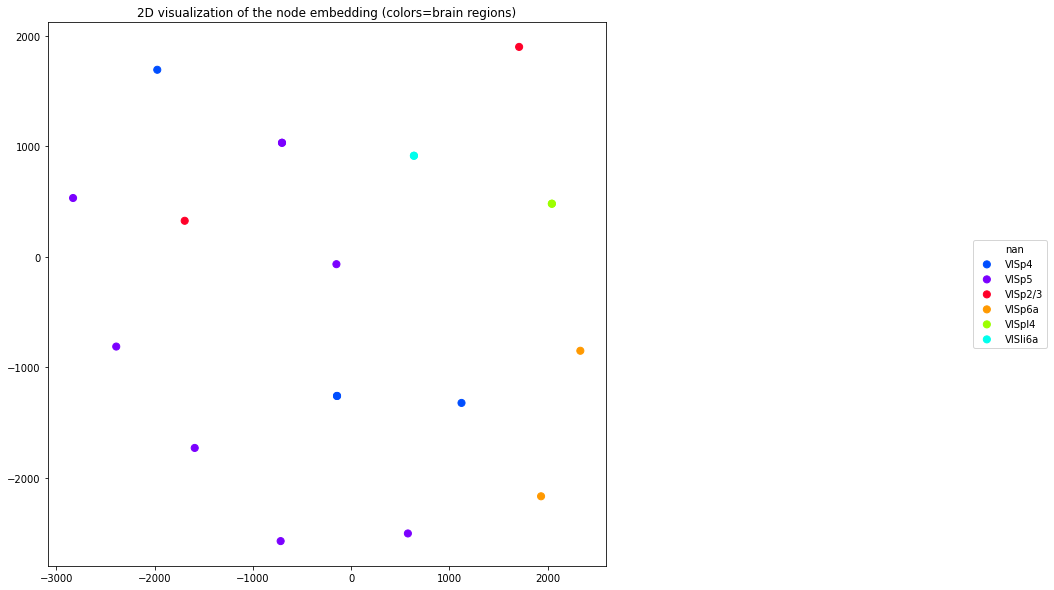

In [238]:
plot_embeddings(
    embeddings_2D, labels,
    "2D visualization of the node embedding (colors=brain regions)",
    ids=None)  # To show id's of points, set `ids=entities`

### Save the embeddings vectors and metadata to disk and in the Nexus project

In [239]:
pd.concat([
    morphologies_df[["id", "brainLocation.brainRegion.label"]],
    ephys_df[["id", "brainLocation.brainRegion.label"]]
]).rename(columns={"id": "resource_id", "brainLocation.brainRegion.label": "brain_region"}).to_csv(
    "metadata_rdf2vec_kg_embeddings.tsv", sep="\t", index=None)

In [240]:
np.savetxt("vectors_rdf2vec_kg_embeddings.tsv", final_embeddings, delimiter="\t")

__Tip__: Try playing with the produced embeddings by loading the saved files in https://projector.tensorflow.org/

### Save the embedding model to disk

In [241]:
transformer.embedder._model.save("./kg_embedding_model")

## Store and index the embeddings in Blue Brain Nexus

### Update morphology and electrophysiology resources with embedding vectors

In [242]:
for i, entity in enumerate(entities):
    resource = forge.retrieve(entity)
    resource.embedding = final_embeddings[i].tolist()
    forge.update(resource)

<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True
<action> _update_one
<succeeded> True


### Create an ElasticSearchView

The goal here is to create an [Elasticsearch](https://www.elastic.co/elasticsearch/) index within the configured Nexus project in which to store and query the embeddings. Such index can be created using an [ElasticSearchView](https://bluebrainnexus.io/docs/delta/api/views/elasticsearch-view-api.html).

In [243]:
VIEW_ID = f"https://bbp.epfl.ch/neurosciencegraph/data/views/es/embedding_view_{int(time.time())}"
DIM = final_embeddings[0].shape[0]  # dimensionality of vectors

In [244]:
type_to_index = [
    "https://neuroshapes.org/NeuronMorphology",
    "https://neuroshapes.org/Trace"
]
view_data = {
    "@type": [
        "ElasticSearchView"
    ],
    "includeMetadata": True,
    "includeDeprecated": False,
    "resourceTypes": type_to_index,
    "mapping": {
        "properties": {
            "@id": {
                "type": "keyword"
            },
            "@type": {
                "type": "keyword"
            },
            "embedding": {
                "type":"dense_vector",
                "dims": DIM
            }
        }
    },
    "sourceAsText": False
}

try:
    response = nexus.views.create_(
        org_label=ORG, project_label=PROJECT,
        payload=view_data, view_id=VIEW_ID)
except nexus.HTTPError as ne:
    print(ne.response.json())

## Recommend similar neuron morphologies and electrophysiology recordings using the embeddings

Configure forge to point to the newly created ElasticSearch view

In [245]:
forge._store.service.elastic_endpoint["endpoint"] = "/".join(
    (ENDPOINT, "views", quote_plus(ORG), quote_plus(PROJECT), quote_plus(VIEW_ID), "_search"))

In [246]:
def get_similar_resources(item_id, q="*", number_of_results=10):
    """Get similar resources.
    
    Given a resource id, execute the recommendation function score query 
    to find similar resources, ranked by cosine similarity.
    """
    # Get the item from Nexus and retrieve its embedding
    item_source = forge.retrieve(id=item_id)
    
    # extract the embedding
    item_embedding = item_source.embedding

    query = f"""{{
          "query": {{
            "script_score": {{
              "query": {{
                    "exists": {{
                        "field": "embedding"
                    }}
              }},
              "script": {{
                "source": "cosineSimilarity(params.query_vector, 'embedding') + 1.0",
                "params": {{
                  "query_vector": {item_embedding}
                }}
              }}
            }}
          }}
        }}"""

    results = forge.elastic(query=query, debug=False, limit=number_of_results)
    scores = [r._score for r in results if hasattr(r, "_score")]
    return [forge.from_json(dict(r._source)) for r in results if hasattr(r, "_source")], scores

Select a morphology id to recommend similar morphologies for.

In [247]:
morphology_id = morphologies_df.id[0]
morphology_id

'https://bbp.epfl.ch/neurosciencegraph/data/neuronmorphologies/99d2c0d4-cfba-42ad-8ac6-297ee84415a7'

In [251]:
morphologies_df[morphologies_df["id"] == morphology_id]

,id,type,brainLocation.brainRegion.id,brainLocation.brainRegion.label,brainLocation.layer,contribution.agent.label,name,subject.type,subject.age.period,subject.age.unitCode,subject.age.value,subject.identifier,subject.name,subject.sex.label,subject.species.label,subject.strain.label
0,https://bbp.epfl.ch/neurosciencegraph/data/neu...,"[Dataset, NeuronMorphology]",http://api.brain-map.org/api/v2/data/Structure...,VISp5,5,Allen Institute for Brain Science,Cux2-CreERT2;Ai14-205530.03.02.01,Subject,Post-natal,,,485250100.0,Cux2-CreERT2;Ai14-205530,,Mus musculus,Cux2-CreERT2


__Important__: Elasticsearch indexing takes a few seconds, if you run the following cells and get no results, most probably the indexing has not finalized yet. Try rerunning in a few seconds.

In [ ]:
number_of_results = 10
forge._debug = True
res, scores = get_similar_resources(
    item_id=morphology_id, 
    number_of_results=number_of_results)

reshaped_res = forge.reshape(res, keep=property_to_display)

print(f"Found {len(res)} Datasets")
result_df = forge.as_dataframe(reshaped_res)
result_df.insert(0, "score", scores)
result_df

Select an electrophysiology recording id to recommend similar electrophysiology recordings for.

In [ ]:
ephys_id = ephys_df.id[0]
ephys_id

In [ ]:
number_of_results = 10
forge._debug= True
res, scores = get_similar_resources(
    item_id=ephys_id,
    number_of_results=number_of_results)

reshaped_res = forge.reshape(res, keep = property_to_display)

print(f"Found {len(res)} Datasets")
result_df = forge.as_dataframe(reshaped_res)
result_df.insert(0, "score", scores)
result_df